# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
%matplotlib inline

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

# Tidying up the data

Implementing consistent capitalization and replacing underscores  spaces with hyphens in the data.

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

<h4> Indexes of the outliers with a bmi above 60 for verification purposes

In [4]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

60.9,64.8,60.2,71.9,78.0,66.8,97.6,63.3,61.2,61.6,64.4,92.0,60.9,

<h4> Cap the outliers at a maximum bmi of 60

In [5]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Preliminary work for binning

In [6]:
##max age of 82, max bin get be set accordingly 
print("The max value in age is : " + str(df['age'].max()))
print("Total number of nulls in age is: " + str(df['age'].isnull().sum())) ##check for null
print("Total number of NAs in age is : " + str(df['age'].isna().sum())) ##check for NAs

The max value in age is : 82.0
Total number of nulls in age is: 0
Total number of NAs in age is : 0


<h2>Unknown_smoking status breakdown

In [7]:
##loop to find the number of unknown smoking entries
unknown_count = 0
##store the indexes of the unknown smoking status entries in case it's needed later
unknown_indexes = []
for index, i in enumerate(df['smoking_status']):
    if(i.lower() == 'unknown'):
        #get index and value 
        #print(index, i)
        unknown_indexes.append(index)
        unknown_count+=1
##get percentage of unknown
unknown_percent = unknown_count/len(df) * 100
unknown_percent = round(unknown_percent,4)
print("\nThe percent of entries with an unknown smoking status is: " + str(unknown_percent) + "% or " +str(unknown_count) + " entries")


The percent of entries with an unknown smoking status is: 30.2153% or 1544 entries


<h2>Checking for non-binary values</h2>
<P>Checked in heart_disease, hypertension, ever_married and stroke. Also converts ever_married to 0/1 instead of yes/no<P>

In [8]:
##check for any non-binary values in heart_disease
non_bin_heart_count = 0
for val in df['heart_disease']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_heart_count == 0):
    print("No non-binary values found in heart_disease")

##check for any non-binary values in hypertension
non_bin_hypt_count = 0
for val in df['hypertension']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_hypt_count == 0):
    print("No non-binary values found in hypertension")
    
##converts ever_married to 0/1 if not already done 
if(isinstance(df['ever_married'][0],str)):
    df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##checks for non-binary values in ever_married
non_bin_married_count = 0
for val in df['ever_married']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_married_count == 0):
    print("No non-binary values found in ever_married")
    
##check for any non-binary values in stroke
non_bin_stroke_count = 0
for val in df['stroke']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_stroke_count == 0):
    print("No non-binary values found in stroke")

No non-binary values found in heart_disease
No non-binary values found in hypertension
No non-binary values found in ever_married
No non-binary values found in stroke


# Impute missing BMI values
<P>Replace missing BMI values with the average BMI found in rows with the same age and gender<P>

In [9]:
##get number of nulls in df
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  218
smoking_status         0
stroke                 0
dtype: int64

In [10]:
df['bmi_raw'] = df['bmi']

df['age'] = df['age'].apply(lambda x : round(x))

m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]


In [11]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
bmi_raw              218
dtype: int64

<h2>Example of imputed values using the outliers above 60</h2>

In [12]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

32.8,33.5,29.1,32.5,27.9,32.3,28.0,26.2,31.5,31.5,27.9,31.8,31.0,

<h2> Equal-width binning implementation</h2>
    <P>Uncomment if you want to use, will not work if equal-size binning has already been implemented
    if you've already applied equal-size, then read in the data-frame again<P>

In [13]:
##define labels and bins using equal width binning
#bins = [0,10,20,30,40,50,60,70,80,90]
#labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90']
##replace all age values with their corresponding bin
#df['age_bin'] = pd.cut(df['age'], bins=bins,labels=labels)

#print("total entires in each bin is:\n", df['age_bin'].value_counts())
#print("\npercentage in each bin is:\n", df['age_bin'].value_counts()/len(df)*100)

<h2> Equal-size binning implementation</h2>


In [14]:
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)
print("total entires in each bin is:\n", df['age_bin'].value_counts())
print("\npercentage in each bin is:\n", df['age_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (57.0, 65.0]    559
(20.0, 30.0]    545
(-0.1, 11.0]    543
(30.0, 38.0]    529
(38.0, 45.0]    519
(51.0, 57.0]    517
(65.0, 75.0]    500
(11.0, 20.0]    482
(75.0, 82.0]    465
(45.0, 51.0]    451
Name: age_bin, dtype: int64

percentage in each bin is:
 (57.0, 65.0]    10.939335
(20.0, 30.0]    10.665362
(-0.1, 11.0]    10.626223
(30.0, 38.0]    10.352250
(38.0, 45.0]    10.156556
(51.0, 57.0]    10.117417
(65.0, 75.0]     9.784736
(11.0, 20.0]     9.432485
(75.0, 82.0]     9.099804
(45.0, 51.0]     8.825832
Name: age_bin, dtype: float64


<h2>Equal-size binning for average-glucose level

In [15]:
##create 10 bins, print values for review
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)
print("total entires in each bin is:\n", df['avg_glucose_level_bin'].value_counts())
print("\npercentage in each bin is:\n", df['avg_glucose_level_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (108.5, 124.2]    512
(80.0, 85.6]      512
(65.8, 73.8]      512
(192.2, 271.7]    511
(98.9, 108.5]     511
(91.9, 98.9]      511
(55.0, 65.8]      511
(124.2, 192.2]    510
(85.6, 91.9]      510
(73.8, 80.0]      510
Name: avg_glucose_level_bin, dtype: int64

percentage in each bin is:
 (108.5, 124.2]    10.019569
(80.0, 85.6]      10.019569
(65.8, 73.8]      10.019569
(192.2, 271.7]    10.000000
(98.9, 108.5]     10.000000
(91.9, 98.9]      10.000000
(55.0, 65.8]      10.000000
(124.2, 192.2]     9.980431
(85.6, 91.9]       9.980431
(73.8, 80.0]       9.980431
Name: avg_glucose_level_bin, dtype: float64


<h2>Equal-size binning for bmi

In [16]:
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)
print("total entires in each bin is:\n", df['bmi_bin'].value_counts())
print("\npercentage in each bin is:\n", df['bmi_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (12.200000000000001, 19.8]    522
(28.2, 29.9]                  520
(24.7, 26.6]                  519
(34.2, 38.6]                  516
(29.9, 31.8]                  514
(22.6, 24.7]                  510
(38.6, 59.7]                  506
(26.6, 28.2]                  503
(19.8, 22.6]                  503
(31.8, 34.2]                  497
Name: bmi_bin, dtype: int64

percentage in each bin is:
 (12.200000000000001, 19.8]    10.215264
(28.2, 29.9]                  10.176125
(24.7, 26.6]                  10.156556
(34.2, 38.6]                  10.097847
(29.9, 31.8]                  10.058708
(22.6, 24.7]                   9.980431
(38.6, 59.7]                   9.902153
(26.6, 28.2]                   9.843444
(19.8, 22.6]                   9.843444
(31.8, 34.2]                   9.726027
Name: bmi_bin, dtype: float64


<h1>Some information about outliers</h1>
<P>Any outliers after binning the ages will be found only in BMI (the most extreme outliers have already been dealt with) and avg_glucose_level. Both columns have a large amount of outliers, the exact number and percentages of which can be seen below. We have not yet done anything with these outliers, simply identified them<P>

<h2>Graphing the outliers

<AxesSubplot:xlabel='bmi'>

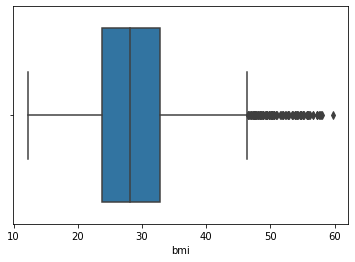

In [17]:
sns.boxplot(x=df['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

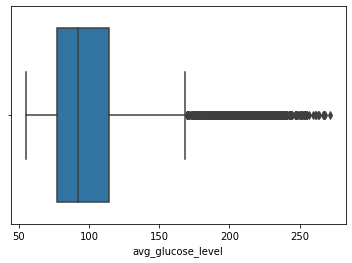

In [18]:
sns.boxplot(x=df['avg_glucose_level'])

<h2>Z-scores to find outliers

<h4>Add in a z-score column to the df

In [19]:
##adds in z-score column to df for bmi and glucose level
cols = ['bmi','avg_glucose_level']
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    
df.head()
##count number of outliers


outliers_bmi_z = np.where((df['bmi_zscore']) >=3)
outliers_glu_z = np.where((df['avg_glucose_level_zscore']) >=3)

outliers_bmi_z = 0
for i in df['bmi_zscore']:
    if(i >=3):
        outliers_bmi_z += 1

outliers_glu_z = 0
for i in df['avg_glucose_level_zscore']:
    if(i >=3):
        outliers_glu_z += 1
        
##get outliers as percentage
z_bmi_percent = outliers_bmi_z/len(df)*100
z_glu_percent = outliers_glu_z/len(df)*100

z_bmi_percent = round(z_bmi_percent,2)
z_glu_percent = round(z_glu_percent,2)

print("number of outliers found with z-score for bmi is : "+ str(outliers_bmi_z) + " which is " +str(z_bmi_percent)+"%")
print("number of outliers found with z-score for glucose is : "+ str(outliers_glu_z) + " which is " +str(z_glu_percent)+"%")

##Uncomment below to get indexes of outliers if needed
#print("Indexes where z-score is greater than 3 for bmi below:\n")
#print(np.where((df['bmi_zscore']) >=3))

#print("\n\nIndexes where z-score is greater than 3 for glucose below:\n")
#print(np.where((df['avg_glucose_level_zscore']) >=3))

number of outliers found with z-score for bmi is : 51 which is 1.0%
number of outliers found with z-score for glucose is : 49 which is 0.96%


<h2>IRQ to find outliers

<h4>Avg_glucose_level

In [20]:
##checking for outliers in avg_glucose_level using iqr
q1_glu = df['avg_glucose_level'].quantile(0.25)
q3_glu = df['avg_glucose_level'].quantile(0.75)
iqr_glu = q3_glu-q1_glu
outliers_glu = (df['avg_glucose_level'] < (q1_glu - 1.5 * iqr_glu)) |(df['avg_glucose_level'] > (q3_glu + 1.5 * iqr_glu))
outliers_glu_count = 0
for i in outliers_glu:
    if(i != False):
        outliers_glu_count += 1
        
iqr_glu_percent = outliers_glu_count/len(df)*100
iqr_glu_percent = round(iqr_glu_percent,2)         
print("number of outliers found with iqr for glucose is : "+ str(outliers_glu_count) + " which is " +str(iqr_glu_percent)+"%")

##uncomment to get the indexes of the outliers if needed
#print("\nIndexes where outliers were detected: ")
#print(np.where(outliers_glu != False))

number of outliers found with iqr for glucose is : 627 which is 12.27%


<h4>BMI

In [21]:
##checking for outliers in bmi using iqr
q1_bmi = df['bmi'].quantile(0.25)
q3_bmi = df['bmi'].quantile(0.75)
iqr_bmi = q3_bmi-q1_bmi
outliers_bmi = (df['bmi'] < (q1_bmi - 1.5 * iqr_bmi)) |(df['bmi'] > (q3_bmi + 1.5 * iqr_bmi))

##count number of outliers
outliers_bmi_count = 0
for i in outliers_bmi:
    if(i != False):
        outliers_bmi_count += 1
        
##get outliers as percentage       
iqr_bmi_percent = outliers_bmi_count/len(df)*100
iqr_bmi_percent = round(iqr_bmi_percent,2) 
print("number of outliers found with iqr for bmi is : "+ str(outliers_bmi_count) + " which is " +str(iqr_bmi_percent)+"%")

##uncomment to get the indexes of the outliers if needed
#print("\nIndexes where outliers were detected: ")
#print(np.where(outliers_bmi != False))

number of outliers found with iqr for bmi is : 110 which is 2.15%


In [22]:
df.describe()

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,bmi_raw,bmi_zscore,avg_glucose_level_zscore
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4892.000000,5.110000e+03,5.110000e+03
mean,36517.829354,43.226614,0.097456,0.054012,0.656164,106.147677,28.827436,0.048728,28.799714,6.651453e-16,3.603293e-15
std,21161.721625,22.612731,0.296607,0.226063,0.475034,45.283560,7.416649,0.215320,7.541793,1.000098e+00,1.000098e+00
min,67.000000,0.000000,0.000000,0.000000,0.000000,55.120000,12.300000,0.000000,12.300000,-2.228642e+00,-1.126958e+00
25%,17741.250000,25.000000,0.000000,0.000000,0.000000,77.245000,23.700000,0.000000,23.500000,-6.914090e-01,-6.383223e-01
50%,36932.000000,45.000000,0.000000,0.000000,1.000000,91.885000,28.200000,0.000000,28.000000,-8.460664e-02,-3.149945e-01
75%,54682.000000,61.000000,0.000000,0.000000,1.000000,114.090000,32.800000,0.000000,33.000000,5.356802e-01,1.754080e-01
max,72940.000000,82.000000,1.000000,1.000000,1.000000,271.740000,59.700000,1.000000,59.700000,4.163010e+00,3.657145e+00


In [23]:
corr_bmi_stroke_spearman = df['bmi'].corr(df['stroke'], method='spearman')
print("spearman's corr for bmi/stroke: ", corr_bmi_stroke_spearman)

corr_bmi_heart_disease_spearman = df['bmi'].corr(df['stroke'], method='spearman')
print("spearman's corr for bmi/heart disease: ", corr_bmi_heart_disease_spearman)

corr_bmi_hypertension_spearman = df['bmi'].corr(df['hypertension'], method='spearman')
print("spearman's corr for bmi/hypertension: ", corr_bmi_hypertension_spearman)

corr_bmi_glucose_spearman = df['bmi'].corr(df['avg_glucose_level'], method='spearman')
print("spearman's corr for bmi/glucose level: ", corr_bmi_glucose_spearman)

corr_bmi_age_spearman = df['bmi'].corr(df['age'], method='spearman')
print("spearman's corr for bmi/age: ", corr_bmi_age_spearman)
print("\n")

corr_bmi_stroke_pearson = df['bmi'].corr(df['stroke'], method='pearson')
print("pearson's corr for bmi/stroke: ", corr_bmi_stroke_pearson)

corr_bmi_heart_disease_pearson = df['bmi'].corr(df['stroke'], method='pearson')
print("pearson's corr for bmi/heart disease: ", corr_bmi_heart_disease_pearson)

corr_bmi_hypertension_pearson = df['bmi'].corr(df['hypertension'], method='pearson')
print("pearson's corr for bmi/hypertension: ", corr_bmi_hypertension_pearson)

corr_bmi_glucose_pearson = df['bmi'].corr(df['avg_glucose_level'], method='pearson')
print("pearson's corr for bmi/glucose level: ", corr_bmi_glucose_pearson)

corr_bmi_age_pearson = df['bmi'].corr(df['age'], method='pearson')
print("pearson's corr for bmi/age: ", corr_bmi_age_pearson)


spearman's corr for bmi/stroke:  0.05855895551806585
spearman's corr for bmi/heart disease:  0.05855895551806585
spearman's corr for bmi/hypertension:  0.165169708526942
spearman's corr for bmi/glucose level:  0.11761086562324173
spearman's corr for bmi/age:  0.37438637536009417


pearson's corr for bmi/stroke:  0.045970863914884794
pearson's corr for bmi/heart disease:  0.045970863914884794
pearson's corr for bmi/hypertension:  0.1543508360317531
pearson's corr for bmi/glucose level:  0.1818797607890085
pearson's corr for bmi/age:  0.3513218942147936


In [24]:
corr_stroke_heart_disease_spearman = df['stroke'].corr(df['heart_disease'], method='spearman')
print("spearman's corr for stroke/heart disease: ", corr_stroke_heart_disease_spearman)

corr_stroke_glucose_spearman = df['stroke'].corr(df['avg_glucose_level'], method='spearman')
print("spearman's corr for stroke/glucose: ", corr_stroke_glucose_spearman)

corr_stroke_hypertension_spearman = df['stroke'].corr(df['hypertension'], method='spearman')
print("spearman's corr for stroke/hypertension: ", corr_stroke_hypertension_spearman)

corr_stroke_age_spearman = df['stroke'].corr(df['age'], method='spearman')
print("spearman's corr for stroke/age: ", corr_stroke_age_spearman)

print("\n")

corr_stroke_heart_disease_pearson = df['stroke'].corr(df['heart_disease'], method='pearson')
print("pearson's corr for stroke/heart disease: ", corr_stroke_heart_disease_pearson)

corr_stroke_glucose_pearson = df['stroke'].corr(df['avg_glucose_level'], method='pearson')
print("pearson's corr for stroke/glucose: ", corr_stroke_glucose_pearson)

corr_stroke_hypertension_pearson = df['stroke'].corr(df['hypertension'], method='pearson')
print("pearson's corr for stroke/hypertension: ", corr_stroke_hypertension_pearson)

corr_stroke_age_pearson = df['stroke'].corr(df['age'], method='pearson')
print("pearson's corr for stroke/age: ", corr_stroke_age_pearson)

spearman's corr for stroke/heart disease:  0.1349139969686927
spearman's corr for stroke/glucose:  0.08254063654762092
spearman's corr for stroke/hypertension:  0.12790382346648016
spearman's corr for stroke/age:  0.24952018424593772


pearson's corr for stroke/heart disease:  0.1349139969686922
pearson's corr for stroke/glucose:  0.13194544082570997
pearson's corr for stroke/hypertension:  0.12790382346648
pearson's corr for stroke/age:  0.24524356886185403


<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

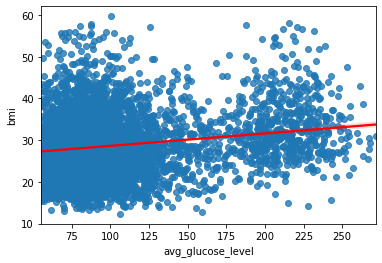

In [25]:
sns.regplot(x=df['avg_glucose_level'],y=df['bmi'], line_kws={"color": "red"})

<AxesSubplot:xlabel='age', ylabel='bmi'>

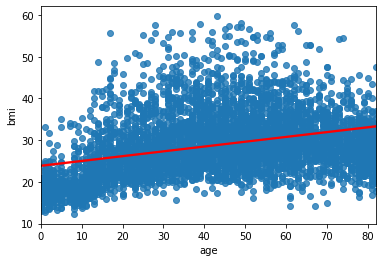

In [26]:
sns.regplot(x=df['age'],y=df['bmi'], line_kws={"color": "red"})

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

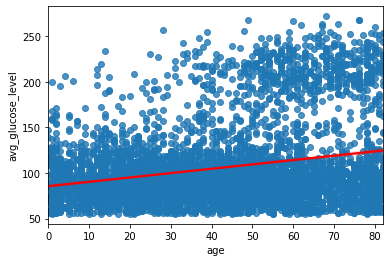

In [27]:
sns.regplot(x=df['age'],y=df['avg_glucose_level'], line_kws={"color": "red"})

In [28]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_raw,age_bin,avg_glucose_level_bin,bmi_bin,bmi_zscore,avg_glucose_level_zscore
0,9046,male,67,0,1,1,private,urban,228.69,36.6,formerly-smoked,1,36.6,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]",1.048091,2.706375
1,51676,female,61,0,0,1,self-employed,rural,202.21,29.1,never-smoked,1,NaN,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]",0.036754,2.121559
2,31112,male,80,0,1,1,private,rural,105.92,32.5,never-smoked,1,32.5,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]",0.495227,-0.005028
3,60182,female,49,0,0,1,private,urban,171.23,34.4,smokes,1,34.4,"(45.0, 51.0]","(124.2, 192.2]","(34.2, 38.6]",0.751432,1.437358
4,1665,female,79,1,0,1,self-employed,rural,174.12,24.0,never-smoked,1,24.0,"(75.0, 82.0]","(124.2, 192.2]","(22.6, 24.7]",-0.650956,1.501184


In [29]:
# sns.pairplot(numerical, 
#              kind='reg', 
#              plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
# plt.show()

<h1> Some useful cross tables</h1>
    <P>For each cross tabulation, we have the counts and values as a percentage<P>

<h3>Bmi bins and stroke

In [30]:
ctab_bmi_stroke = pd.crosstab(df.bmi_bin,df.stroke)
ctab_bmi_stroke

stroke,0,1
bmi_bin,,
"(12.200000000000001, 19.8]",518,4
"(19.8, 22.6]",489,14
"(22.6, 24.7]",491,19
"(24.7, 26.6]",498,21
"(26.6, 28.2]",464,39
"(28.2, 29.9]",487,33
"(29.9, 31.8]",469,45
"(31.8, 34.2]",471,26
"(34.2, 38.6]",490,26


In [31]:
(ctab_bmi_stroke.transpose() / ctab_bmi_stroke.sum(axis=1)).transpose()

stroke,0,1
bmi_bin,,
"(12.200000000000001, 19.8]",0.992337,0.007663
"(19.8, 22.6]",0.972167,0.027833
"(22.6, 24.7]",0.962745,0.037255
"(24.7, 26.6]",0.959538,0.040462
"(26.6, 28.2]",0.922465,0.077535
"(28.2, 29.9]",0.936538,0.063462
"(29.9, 31.8]",0.912451,0.087549
"(31.8, 34.2]",0.947686,0.052314
"(34.2, 38.6]",0.949612,0.050388


<h3>Ever_married and stroke

In [32]:
ctab_married_stroke = pd.crosstab(df.ever_married,df.stroke)
ctab_married_stroke

stroke,0,1
ever_married,,
0,1728,29
1,3133,220


In [33]:
(ctab_married_stroke.transpose() / ctab_married_stroke.sum(axis=1)).transpose()

stroke,0,1
ever_married,,
0,0.983495,0.016505
1,0.934387,0.065613


<h3>Smoking and stroke

In [34]:
ctab_smoke_stroke = pd.crosstab(df.smoking_status,df.stroke)
ctab_smoke_stroke

stroke,0,1
smoking_status,,
formerly-smoked,815,70
never-smoked,1802,90
smokes,747,42
unknown,1497,47


In [35]:
(ctab_smoke_stroke.transpose() / ctab_smoke_stroke.sum(axis=1)).transpose()

stroke,0,1
smoking_status,,
formerly-smoked,0.920904,0.079096
never-smoked,0.952431,0.047569
smokes,0.946768,0.053232
unknown,0.969560,0.030440


<h3>Age and stroke

In [36]:
ctab_age_stroke = pd.crosstab(df.age_bin,df.stroke)
ctab_age_stroke

stroke,0,1
age_bin,,
"(-0.1, 11.0]",542,1
"(11.0, 20.0]",481,1
"(20.0, 30.0]",545,0
"(30.0, 38.0]",526,3
"(38.0, 45.0]",511,8
"(45.0, 51.0]",437,14
"(51.0, 57.0]",491,26
"(57.0, 65.0]",519,40
"(65.0, 75.0]",440,60


In [37]:
(ctab_age_stroke.transpose() / ctab_age_stroke.sum(axis=1)).transpose()

stroke,0,1
age_bin,,
"(-0.1, 11.0]",0.998158,0.001842
"(11.0, 20.0]",0.997925,0.002075
"(20.0, 30.0]",1.000000,0.000000
"(30.0, 38.0]",0.994329,0.005671
"(38.0, 45.0]",0.984586,0.015414
"(45.0, 51.0]",0.968958,0.031042
"(51.0, 57.0]",0.949710,0.050290
"(57.0, 65.0]",0.928444,0.071556
"(65.0, 75.0]",0.880000,0.120000


<h3>hypertension and stroke

In [38]:
ctab_hyper_stroke = pd.crosstab(df.hypertension,df.stroke)
ctab_hyper_stroke

stroke,0,1
hypertension,,
0,4429,183
1,432,66


In [39]:
(ctab_hyper_stroke.transpose() / ctab_hyper_stroke.sum(axis=1)).transpose()

stroke,0,1
hypertension,,
0,0.960321,0.039679
1,0.867470,0.132530


<h3>heart disease and stroke

In [40]:
ctab_heart_disease_stroke = pd.crosstab(df.heart_disease,df.stroke)
ctab_heart_disease_stroke

stroke,0,1
heart_disease,,
0,4632,202
1,229,47


In [41]:
(ctab_heart_disease_stroke.transpose() / ctab_heart_disease_stroke.sum(axis=1)).transpose()

stroke,0,1
heart_disease,,
0,0.958213,0.041787
1,0.829710,0.170290


<h3>Glucose and stroke

In [42]:
ctab_glucose_disease_stroke = pd.crosstab(df.avg_glucose_level_bin,df.stroke)
ctab_glucose_disease_stroke

stroke,0,1
avg_glucose_level_bin,,
"(55.0, 65.8]",492,19
"(65.8, 73.8]",490,22
"(73.8, 80.0]",488,22
"(80.0, 85.6]",498,14
"(85.6, 91.9]",494,16
"(91.9, 98.9]",493,18
"(98.9, 108.5]",492,19
"(108.5, 124.2]",493,19
"(124.2, 192.2]",478,32


In [43]:
(ctab_glucose_disease_stroke.transpose() / ctab_glucose_disease_stroke.sum(axis=1)).transpose()

stroke,0,1
avg_glucose_level_bin,,
"(55.0, 65.8]",0.962818,0.037182
"(65.8, 73.8]",0.957031,0.042969
"(73.8, 80.0]",0.956863,0.043137
"(80.0, 85.6]",0.972656,0.027344
"(85.6, 91.9]",0.968627,0.031373
"(91.9, 98.9]",0.964775,0.035225
"(98.9, 108.5]",0.962818,0.037182
"(108.5, 124.2]",0.962891,0.037109
"(124.2, 192.2]",0.937255,0.062745



# Visualisations
# Joint Plots
## Age and BMI
This shows that the stroke population is heavily skewed towards older individuals.
It also suggests that a lower BMI is associated with a lower stroke risk before the age of 70.

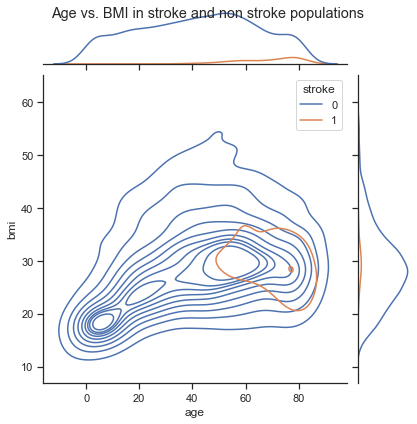

In [44]:
sns.set_theme(style="ticks")

g1 = sns.jointplot(
    data=df,
    x="age", y="bmi", hue="stroke",
    kind="kde",
)
g1.fig.suptitle("Age vs. BMI in stroke and non stroke populations");



## Age and glucose level
This shows that age is a factor, but that average glucose level follows the same average distribution in both stroke and no stroke populations, and is therefore not related.

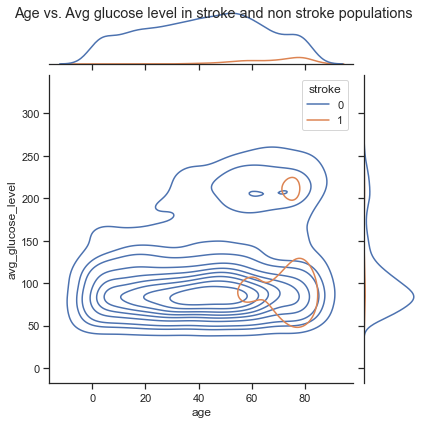

In [45]:
g2 = sns.jointplot(
    data=df,
    x="age", y="avg_glucose_level", hue="stroke",
    kind="kde",
)
g2.fig.suptitle("Age vs. Avg glucose level in stroke and non stroke populations");


## Glucose level and BMI
This suggests that, at higher average glucose levels, a lower BMI is slightly linked to an increased stroke risk, but to a likely insignificant degree.

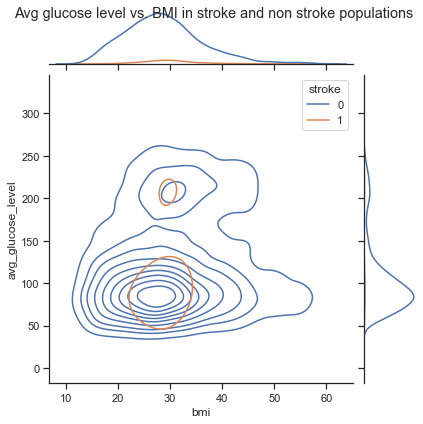

In [46]:
g3 = sns.jointplot(
    data=df,
    x="bmi", y="avg_glucose_level", hue="stroke",
    kind="kde",
)
g3.fig.suptitle("Avg glucose level vs. BMI in stroke and non stroke populations");

In [47]:
def comparative_histogram(df, column):
    weights_neg = np.ones_like(df[df['stroke'] == 0][column]) / len(df[df['stroke'] == 0][column])
    weights_pos = np.ones_like(df[df['stroke'] == 1][column]) / len(df[df['stroke'] == 1][column])

    a = sns.histplot(
        df[df['stroke'] == 0],
        x=column,
        bins=20,
        alpha=0.5,
        weights=weights_neg,
        color='g',
        label='No stroke'
        )

    sns.histplot(
        df[df['stroke'] == 1],
        x=column,
        bins=20,
        alpha=0.5,
        weights=weights_pos,
        color='r',
        label='Stroke'
        )
    plt.legend()
    a.set_title(f'Distribution of {column} in stroke and no stroke populations')

# Comparing positive and negative label populations
The comparative_histogram function plots the distributions of a feature in both the positive and negative label populations. It normalises the distributions so that they can be compared side by side.
## Average glucose level
This suggests that a higher glucose level is associated with a higher risk of stroke, and that a lower level is associated with a lower risk

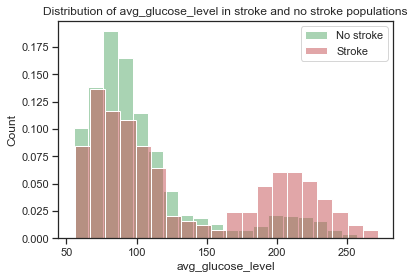

In [48]:
comparative_histogram(df, 'avg_glucose_level')

## BMI
This suggests that stroke risk is skewed towards a higher BMI.

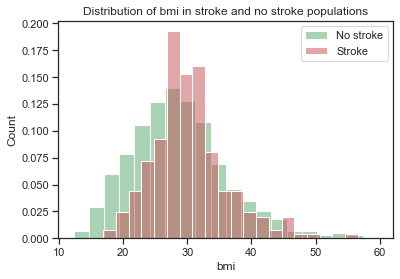

In [49]:
comparative_histogram(df, 'bmi')

## Age
This suggests that age plays a large role in stroke risk

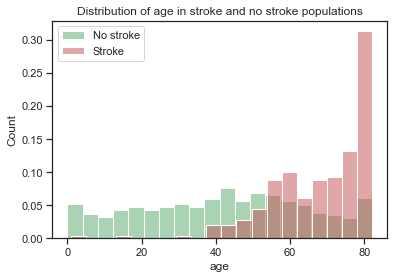

In [50]:
comparative_histogram(df, 'age')

## Smoking status
This suggests that having formerly smoked is associated with a higher risk of stroke, and that an unknown smoking status is associated with a lower risk

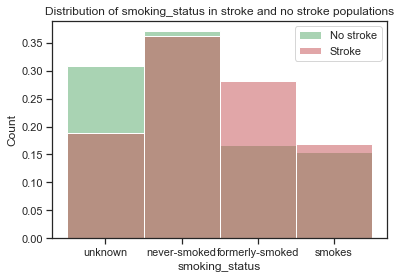

In [51]:
comparative_histogram(df, 'smoking_status')

# Resampling to Avoid Intercorrelation With Age
It's clear from the data that age plays a large role in stroke risk. Thus, the previously suggested relationships between the other dataset features and stroke risk may simply be because these features are also related to age. 

Below the age of 40, the frequency of strokes is low enough to be considered insignificant. Therefore, it may be usueful to examine only individuals of the age where stroke risk is significant. We will resample the data to include only individuals within 2 standard deviations of the mean stroke age. This new data set includes 96% of all positive labels.


In [52]:
# Find standard deviation of age in stroke victim - take age range of 2 standard deviations in age,
# then compare heart disease, employment, etc.

stroke_mean_age = df[df['stroke'] == 1].age.mean()
stroke_age_sd = df[df['stroke'] == 1].age.std()

print(f'Mean stroke age is {stroke_mean_age:.2f}')
print(f'New data set will include examples between the ages of {stroke_mean_age - stroke_age_sd * 2:.2f} and {stroke_mean_age + stroke_age_sd * 2:.2f}')

# All examples X where X.age is within 1 SD of median stroke age
# df1sd = df[(df['age'] > stroke_mean_age - stroke_age_sd) & (df['age'] < stroke_mean_age + stroke_age_sd)]

# All examples X where X.age is within 2 SD of median stroke age
df2sd = df[(df['age'] > stroke_mean_age - stroke_age_sd * 2) & (df['age'] < stroke_mean_age + stroke_age_sd * 2)]
 
# print(f'Dataset counts \nMain data set: {len(df)} \nWithin 1 SD of mean stroke age: {len(df1sd)} \nWithin 2 SD of mean stroke age: {len(df2sd)}')
print(f'Dataset df2sd contains {len(df2sd)} examples of the main dataset\'s {len(df)}, and {len(df2sd[df2sd.stroke == 1]) / len(df[df.stroke == 1]) * 100:.2f}% of all positive labels')

Mean stroke age is 67.73
New data set will include examples between the ages of 42.26 and 93.20
Dataset df2sd contains 2722 examples of the main dataset's 5110, and 96.39% of all positive labels


## Smoking status
When comparing smoking status using the new dataset, the differences are much less pronounced. Having never smoked shows a very slightly lower rate of strokes. Having formerly smoked shows a slightly higher rate of strokes.

The heat map below also shows why the "unknown" status was associated with such a low incidence of strokes: it seems to be frequently assigned to children.

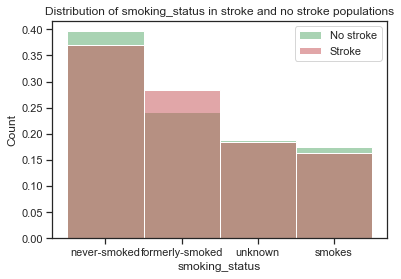

In [53]:
comparative_histogram(df2sd, 'smoking_status')

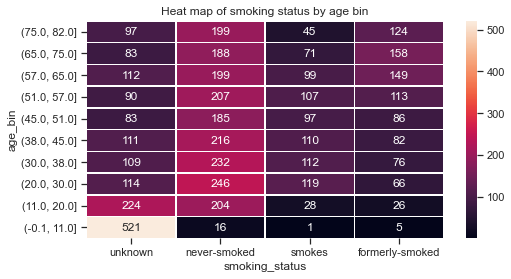

In [66]:
table = pd.pivot_table(df, values='stroke', index=['age_bin'],
                    columns=['smoking_status'], aggfunc=lambda x: len(x))[['unknown', 'never-smoked', 'smokes', 'formerly-smoked']]


table.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(table, annot=True, fmt='d', linewidths=.5, ax=ax)
ax.set_title('Heat map of smoking status by age bin');


## BMI
The distribution of BMI is now much more similar for the two populations, indicating that the higher stroke incidence in higher BMI indviduals suggest earler was actualy due to an association between BMI and age.

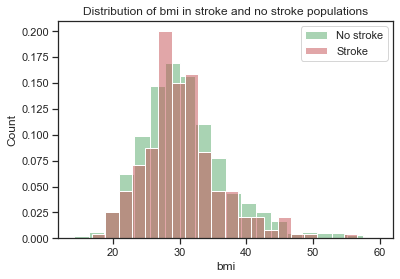

In [57]:
comparative_histogram(df2sd, 'bmi')

## Average glucose level
The higher stroke incidence in high glucose level individuals, shown above for the entire population, appears again in our resampled data set, implying that this relationship is independent of age.

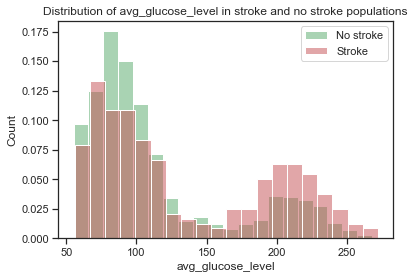

In [58]:
comparative_histogram(df2sd, 'avg_glucose_level')

# Comparing Binary Attributes Between Main and Resampled Datasets
To compare the percentage of positive and negative values for the binary attributes, we'll used pie charts. The left two pie charts use the main population and the right two use the resampled population.

In [59]:
def compare_piecharts(column):
    fig, ax = plt.subplots(1, 4, figsize=(10,6))
    fig.suptitle= 'TEST'
    ax[0].pie(df[df['stroke'] == 1][column].value_counts(), labels=[0, 1]);
    ax[0].set_title(f'Main population\n{column} where stroke = 1')
    ax[1].pie(df[df['stroke'] == 0][column].value_counts(), labels=[0, 1]);
    ax[1].set_title(f'Main population\n{column} where stroke = 0')
    ax[2].pie(df2sd[df2sd['stroke'] == 1][column].value_counts(), labels=[0, 1]);
    ax[2].set_title(f'Resampled population\n{column} where stroke = 1')
    ax[3].pie(df2sd[df2sd['stroke'] == 0][column].value_counts(), labels=[0, 1]);
    ax[3].set_title(f'Resampled population\n{column} where stroke = 0');
    fig.tight_layout()

## Hypertension
Where the full dataset suggests a relationship between hypertension and stroke, as seen by the difference between the first two pie charts, the resampled dataset suggests that part - thought not necessarily all - of this relationship is due to a link between hypertension and age.

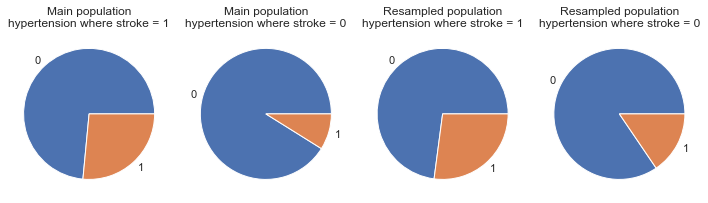

In [60]:
compare_piecharts('hypertension')

## Heat Disease
As above, here the relationship between stroke and heart disease is less apparent in the resampled population, although still present.

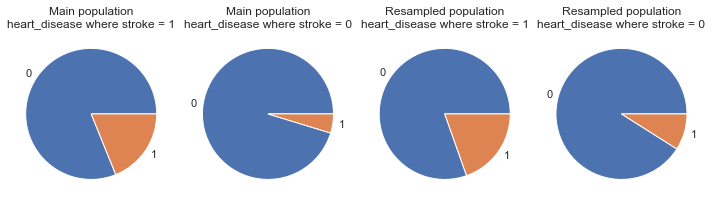

In [61]:
compare_piecharts('heart_disease')

## Ever Married
This, thankfully, shows that the relationship between marriage and strokes seen in the first two pie charts can be attributed to a relationship between marriage and age.

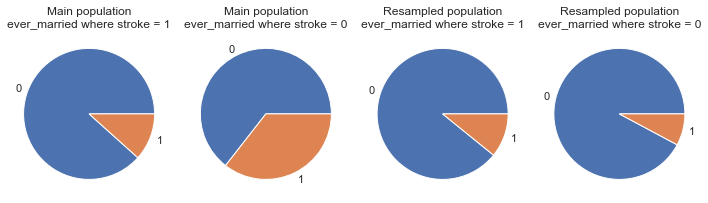

In [62]:
compare_piecharts('ever_married')

# Chi Squared
Chi squared is a test used to determine whether there is a statistically significant between the expected and the observed frequencies of values in a contingency table. If the chi squared p value is less than the significance threshold (we'll use 0.05), then the null hypothesis is rejected and some dependency between the values is signalled.

We will use this test on both the full population and the resampled population to investigate what effect the resampling has had.

In [63]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def compare_chi2(column):
    ctab_full = pd.crosstab(df[column],df.stroke)
    c1, p1, dof1, expected1 = chi2_contingency(ctab_full)
    
    ctab_resampled = pd.crosstab(df2sd[column],df.stroke)
    c2, p2, dof2, expected2 = chi2_contingency(ctab_resampled)
    
    significance_level = 0.05
    
    print(col.upper())
    print(f'Chi squared p value for full population = {p1:.4f}')
    if p1 < significance_level:
        print(f'Null hypothesis can be rejected; {column} values in main population are dependent')
    else:
        print(f'Null hypothesis cannot be rejected; {column} values in main population are independent')
        
    print(f'Chi squared p value for resampled population = {p2:.4f}')
    if p2 < significance_level:
        print(f'Null hypothesis can be rejected; {column} values in resampled population are dependent')
    else:
        print(f'Null hypothesis cannot be rejected; {column} values in resampled population are independent')

In [64]:
for col in ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']:
    compare_chi2(col)


HYPERTENSION
Chi squared p value for full population = 0.0000
Null hypothesis can be rejected; hypertension values in main population are dependent
Chi squared p value for resampled population = 0.0000
Null hypothesis can be rejected; hypertension values in resampled population are dependent
HEART_DISEASE
Chi squared p value for full population = 0.0000
Null hypothesis can be rejected; heart_disease values in main population are dependent
Chi squared p value for resampled population = 0.0000
Null hypothesis can be rejected; heart_disease values in resampled population are dependent
EVER_MARRIED
Chi squared p value for full population = 0.0000
Null hypothesis can be rejected; ever_married values in main population are dependent
Chi squared p value for resampled population = 0.1302
Null hypothesis cannot be rejected; ever_married values in resampled population are independent
WORK_TYPE
Chi squared p value for full population = 0.0000
Null hypothesis can be rejected; work_type values in m

## Chi Squared Test Results
According to our Chi Squared tests performed on the full population, hypertension, heart disease, marriage, work type, and smoking status are dependent and therefore related in some way to stroke risk. However, after resampling in order to control for age correlations, our Chi Squared tests found that only hypertension and heart disease were related to stroke risk, and that marriage, work type, residence type, and smoking status were not related.